NMT (seq2seq) in fastai v1

Start with this:<br>
https://gist.github.com/ohmeow/fe91aed6267cd779946ab9f10eccdab9

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import *
import copy

# Load data, split, build DataBunch

In [4]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    x_max_len = max([len(s[0]) for s in samples])
    y_max_len = max([len(s[1]) for s in samples])
    
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    return x_res, y_res

class Seq2SeqDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:        
        """Function that transform the `datasets` in a `DataBunch` for classification.  Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch    

In [5]:
PATH = Path('./data/seq2seq/')
bs = 64

## load the saved data.
data = load_data(PATH, "full_es_en_data_spacyTok.pkl")

In [6]:
b = next(iter(data.train_dl))
b[0].shape, b[1].shape

(torch.Size([64, 255]), torch.Size([64, 252]))

In [7]:
b[0][12,:].shape

torch.Size([255])

In [8]:
b[1][12,:-1], b[1][12,1:]

(tensor([    2,     5,    22,    72,    10,   123,   593,  3213,    10,    17,
            75,   404,    10,    11,  1790,    20,     5,   111,     5,  4025,
            10,    43,     9,    11,    35,    10,    20,     5,   111,     5,
          7307,    10,  5347,    20,     5,   124,     6,  1341,    10,     9,
            11,     5,   333,     5, 13588,  2860,     5, 55229,    10,  6873,
          2743,    10, 13823,    20,     5,   124,     6,  2287,    10,    20,
             5,   111,     5,  9858,     5, 10164,    10,    13,    31,   561,
            50,  5213,    22,    23,   302,   383,   231,    10,    16,     9,
           127,  1569,    36,    12,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [9]:
len(data.label_list.train.x.vocab.itos), len(data.label_list.train.y.vocab.itos)

(35541, 58838)

In [10]:
len(data.label_list.train.x.vocab.itos), data.label_list.train.vocab.itos[:20]

(35541,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'to',
  'and',
  'in',
  'that',
  'a',
  'is',
  'we'])

In [11]:
len(data.label_list.train.y.vocab.itos), data.label_list.train.y.vocab.itos[:20]

(58838,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'de',
  ',',
  'la',
  '.',
  'que',
  'en',
  'el',
  'y',
  'a',
  'los',
  'las'])

# Build a model for Seq2Seq

Big help from this link from the old course + looking at the `Transformer` code and adapting <br>
https://github.com/kheyer/ML-DL-Projects/blob/master/Seq2Seq%20Transformer/Transformer.ipynb

and here:<br>
https://nbviewer.jupyter.org/github/fastai/fastai/blob/6ba17b21599a6fc441794ffd130bc31b5333b4a0/courses/dl2/translate.ipynb



In [12]:
from torch.autograd import Variable

In [13]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)
    
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False).cuda()
        return x  

In [14]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
        
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.2):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
                
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output

In [16]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.2):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm   

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
        
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [18]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, 255)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, 252)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)


In [19]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def reset(self): pass
    def forward(self, src, trg, src_mask=None, trg_mask=None):
        if src_mask is None:
            src_mask, trg_mask = create_masks(src, trg)
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return [output, output, output]

In [20]:
## flip sign on this?  is 1/0 different for our masking convention?
def nopeak_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask =  (torch.from_numpy(np_mask) == 0).cuda()

    return np_mask

def create_masks(src, trg):
    
    src_mask = (src != 1).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != 1).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size).cuda()

        trg_mask = trg_mask & np_mask
        
    else:
        trg_mask = None
        
    return src_mask, trg_mask

def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))

In [21]:
d_model = 300
heads = 10
N = 6

src_vocab = len(data.label_list.train.x.vocab.itos)
trg_vocab = len(data.label_list.train.y.vocab.itos)
model = to_device(Transformer(src_vocab, trg_vocab, d_model, N, heads), defaults.device)

In [22]:
model

Transformer(
  (encoder): Encoder(
    (embed): Embedder(
      (embed): Embedding(35541, 300)
    )
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=300, out_features=300, bias=True)
          (v_linear): Linear(in_features=300, out_features=300, bias=True)
          (k_linear): Linear(in_features=300, out_features=300, bias=True)
          (dropout): Dropout(p=0.2)
          (out): Linear(in_features=300, out_features=300, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=300, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2)
          (linear_2): Linear(in_features=2048, out_features=300, bias=True)
        )
        (dropout_1): Dropout(p=0.1)
        (dropout_2): Dropout(p=0.1)
      )
      (1): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (at

## Build Seq2SeqTransformer

In [23]:
@dataclass
class AppendBatchTargs(Callback):
    "Include the target in the training loop for Decoder mask"
    learn:Learner
    def __init__(self):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target[:,:-1]),
                'last_target':last_target[:,1:]}

In [24]:
class Seq2SeqLearner(RNNLearner):
    "Subclass of RNNLearner for predictions using Seq2Seq"
    
    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
                decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text`."
        ## handle predictions for Seq2Seq
        set_trace()
        ds = self.data.single_dl.dataset
        self.model.reset()
        xb,yb = self.data.one_item(text)
        new_idx = []
        for _ in range(n_words): #progress_bar(range(n_words), leave=False):
            res = self.pred_batch(batch=(xb,yb))[0][-1]
            #if len(new_idx) == 0: self.model[0].select_hidden([0])
            if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
            if min_p is not None: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            new_idx.append(idx)
            xb = xb.new_tensor([idx])[None]
        return text + sep + sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

In [25]:
'''
(Pdb) output.shape
torch.Size([16, 251, 58838])
(Pdb) src.shape
torch.Size([16, 255])
(Pdb) trg.shape
torch.Size([16, 251])
'''

def seq2seq_loss(input, target):
#     sl,bs = target.size()
#     sl_in,bs_in,nc = input.size()
    bs,sl = target.size()
    bs_in,sl_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:,:sl,:]
    if input.shape[0] != target.shape[0]:
        set_trace()
    return F.cross_entropy(input.view(-1,nc), target.contiguous().view(-1))

In [26]:
learn = Seq2SeqLearner(data, model, **{'alpha':0,'beta':0}, callbacks=[AppendBatchTargs()], loss_func=CrossEntropyFlat())
learn.unfreeze()

In [27]:
learn.loss_func = seq2seq_loss

In [28]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'67,318,514'

In [29]:
learn.data.batch_size = 16  ## 64 fails to load.  Prob. too big embedding matrix.

In [30]:
learn.fit(1, lr=3e-3)

epoch,train_loss,valid_loss,time
0,3.302774,4.356208,2:09:32


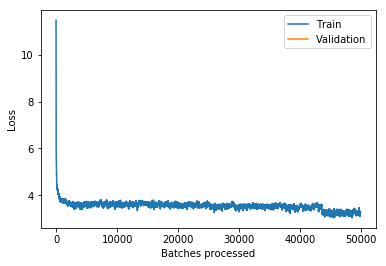

In [31]:
learn.recorder.plot_losses()

In [32]:
x,y = next(iter(learn.data.valid_dl))
preds = learn.model(x,y)
preds[0][0,:].argmax(dim=-1)

tensor([ 12,  22, 299,  35,  12,  12,  12,  12, 209,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  

In [33]:
x_itos = data.label_list.train.x.vocab.itos
y_itos = data.label_list.train.y.vocab.itos

In [34]:
i = 0
for i in range(5):
    print(' '.join([x_itos[o] for o in x[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in y[i,:] if o != 1]))
    print(' '.join([y_itos[o] for o in preds[0][i,:].argmax(dim=1) if o!=1]))
    print()

xxbos xxmaj the xxmaj commission can not accept amendments 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 71 , 75 , 77 , 80 , 82 , 84 , 85 , 86 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 98 , 99 , 100 , 106 , 109 , 110 , 111 , 112 , 113 , 114 , 118 , 129 , 131 , 133 , 134 , 135 , 136 , 137 , 138 , 143 , 150 , 151 , 152 , 153 , 154 , 155 , 156 , 160 , 162 , 164 , 166 , 167 , 168 , 169 , 170 , 173 , 174 , 177 , 178 , 179 , 182 , 189 , 206 , 212 , 214 , 216 , 218 , 219 , 222 , 223 , 224 , 225 , 226 , 227 , 228 , 229 , 230 , 231 , 232 , 233 , 234 , 237 , 238 , 239 , 240 ,
xxbos xxmaj la xxmaj comisión no puede aceptar las enmiendas 1 , 2 , 3 , 5 , 6 , 7 , 9 , 12 , 13 , 15 , 17 , 22 , 23 , 24 , 25 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 35 , 37 , 38 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 51 , 52 , 54 , 55 , 56 , 57 , 58 , 66 , 69 , 70 , 7

In [35]:
inp, src_mask = learn.model.encode_source(x[i,:].unsqueeze(0))
i,x.shape,inp.shape,src_mask

AttributeError: 'Transformer' object has no attribute 'encode_source'

In [ ]:
targ = learn.model.decode_target(inp, src_mask, y[i,:].unsqueeze(0))
learn.model.tgt_word_prj(targ).shape

In [ ]:
learn.model.tgt_word_prj(targ).argmax(dim=-1)

In [ ]:
learn.data.vocab.itos[:10]

In [ ]:
    def forward(self, x, y):
        #encode layers
        inp, src_mask = self.encode_source(x)
        targ = self.decode_target(inp, src_mask, y)
        decoded = self.tgt_word_prj(targ) * self.x_logit_scale
        return [decoded, inp, targ]

In [ ]:
y.shape

In [ ]:
memory, src_mask = learn.model.encode_source(x[i,:].unsqueeze(0))
# ys = torch.ones(1, 1).fill_(learn.data.vocab.stoi[BOS]).type_as(x.data)
# ys = torch.ones(1, 1).fill_(42).type_as(x.data)

## make the y's side right!!! other wise POS encoding is wrong!
ys = torch.ones(1, 252).type_as(x.data)
ys[0][0] = 2
ys

In [ ]:
max_len=3
for _ in range(max_len-1):
    out = learn.model.decode_target(memory, src_mask, ys)[:,-1,:] #latest word estimate, can't change history.
    prob = F.softmax(learn.model.tgt_word_prj(out),dim=-1)
    next_i = learn.model.tgt_word_prj(out).argmax(dim=-1).item()
    ys = torch.cat([ys, torch.ones(1,1).type_as(x.data).fill_(next_i)],dim=1)
    print(ys)

In [ ]:
prob, torch.multinomial(prob,1)

In [ ]:
targ = learn.model.decode_target(memory, src_mask, y[i,:].unsqueeze(0))
learn.model.tgt_word_prj(targ).argmax(dim=-1)

### Allow modification of prior words

In [ ]:
memory, src_mask = learn.model.encode_source(x[i,::].unsqueeze(0))
ys = torch.ones(1, 1).fill_(learn.data.vocab.stoi[BOS]).type_as(x.data)
print(ys)

In [ ]:
out = learn.model.decode_target(memory, src_mask, ys)
out.shape

In [ ]:
learn.model.tgt_word_prj(out).argmax(dim=-1)

In [ ]:
prob = F.softmax(learn.model.tgt_word_prj(out),dim=-1)
next_i = learn.model.tgt_word_prj(out).argmax(dim=-1).item()
ys = torch.cat([ys, torch.ones(1,1).type_as(x.data).fill_(next_i)],dim=1)
print(ys)

In [ ]:
learn.model.tgt_word_prj(learn.model.decode_target(memory, src_mask, ys)).argmax(dim=-1)

In [ ]:
torch.multinomial(prob.squeeze(), 1)

In [ ]:
ys

In [ ]:
learn.model.tgt_word_prj(out).argmax(dim=-1).item()

In [ ]:
max_len=10
for i in range(max_len-1):

    out = model.decoder(Variable(ys), memory, src_mask, Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
    prob = F.softmax(model.out(out[:, -1]))
    #_, next_word = torch.max(prob, dim = 1)
    next_word = torch.multinomial(prob, 1)
    next_word = next_word.data[0][0]
    ys = torch.cat([ys, 
                    torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)

In [ ]:
## need to separate encoder/decoder parts.
### Tranaslation will be:
# * Set state from src sentence in encoder (torch.no_grad() to keep state?)
# * start with xxbos token
# * proceed through each step with next word (example below)
# * OR:  beam_search() to get best set of next words up to end.  

In [ ]:
## can we use this encoder as a LM for english??